# LeNet-5(Pytorch)

![](../../../picture/177.png)
该模型是原文模型,在C3层以及最后的Gaussian Connections是比较难实现的.我们目前而言对该模型做一些调整:

- 原文sigmoid激活函数,更改为ReLu函数

- C3层依然使用普通采样

- 由于输入为$(32,32)$,Minis数据集为$(28,28)$,所以我们输入层需要padding.

- 输出层我们不再采用Gaussian connection,转而使用softmax.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Load Dataset

这里使用Keras数据集中的Minist数据集,train set 60K,test set 10K.

这里将样本拆分为: train set 60K,validation set 7K, test set 3K.同时将样本reshape为$(1,28,28)$.

In [2]:
def loadDataset(index,split_rate):
    """
    Load data set.
    
    Arguments:
    ---------
        index: show index images.
        split_rate: validation set and test set split rate.
    
    Returns:
    -------
        x_train: training set shape is (m,n_c,n_h,n_w)
        y_train: training labels shape is (m,)
        x_val: validation set shape is (m,n_c,n_h,n_w)
        y_val: validation labels shape is (m,)
        x_test: testing set shape is (m,n_c,n_h,n_w)
        y_test: testing labels shape is (m,)
    """
    (x_train,y_train),(X,Y) = mnist.load_data()

    
    plt.imshow(x_train[index],cmap='gray')
    plt.show()
    
    x_train,X = x_train / 255,X/255
    x_val, x_test, y_val, y_test = train_test_split(X, Y, test_size=split_rate)
    
    x_train = x_train.reshape((-1,1,28,28))
    x_val = x_val.reshape((-1,1,28,28))
    x_test = x_test.reshape((-1,1,28,28))
    
    print('Training Set shape is:\n',x_train.shape)
    print('Training Labels shape is:\n',y_train.shape)
    print('Validation Set shape is:\n',x_val.shape)
    print('Validation Labels shape is:\n',y_val.shape)
    print('Testing Set shape is:\n',x_test.shape)
    print('Testing Labels shape is:\n',y_test.shape)
    
    return x_train,y_train,x_val,y_val,x_test,y_test

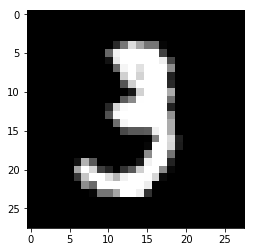

Training Set shape is:
 (60000, 1, 28, 28)
Training Labels shape is:
 (60000,)
Validation Set shape is:
 (7000, 1, 28, 28)
Validation Labels shape is:
 (7000,)
Testing Set shape is:
 (3000, 1, 28, 28)
Testing Labels shape is:
 (3000,)


In [3]:
x_train,y_train,x_val,y_val,x_test,y_test = loadDataset(10,0.3)

## Forward

接下去我们来构建Forward.网络结构为:

INPUT(batch,1,32,32)-->CONV1(batch,6,28,28)-->Relu1-->Average Pool1(batch,6,14,14)-->CONV2(batch,16,10,10)-->ReLu2-->Average Pool2(16,5,5)-->FC3(batch,120)-->FC4(batch,84)-->FC5(batch,10)

In [4]:
class Module(nn.Module):
    """
    Build Forward Class Model.
    """
    def __init__(self):
        """
        Initialization Class Module.
        """
        nn.Module.__init__(self)
        # CONV layers
        self.CONV = nn.ModuleList([
            nn.Conv2d(1,6,kernel_size=(5,5),stride=(1,1)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
            nn.ReLU(),
            nn.Conv2d(6,16,kernel_size=(5,5),stride=(1,1)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(2,2),stride=(2,2)),
        ])
        # Fully Connect layers.
        self.FULLY_CONNECT = nn.ModuleList([
            nn.Linear(400,120),
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,10)
        ])
        # Change initialize weight in CONV and FC.
        [nn.init.xavier_normal_(m.weight) for m in self.CONV if m.__class__.__name__ != "ReLU" and m.__class__.__name__ != "AvgPool2d"]
        [nn.init.xavier_normal_(m.weight) for m in self.FULLY_CONNECT if m.__class__.__name__ != "ReLU"]
        
    def forward(self,X):
        """
        Forward propagation.
        
        Arguments:
        ---------
            X: training data set.
        Return:
        ------
            X: output layer value, the shape is (batch,n_classes).
        Notic:
        ------
            1.The output layers must be not use any activation function ! We use nn.CrossEntropyLoss() loss func.
            2.The papaer Input shape is (32,32),so we need pad=2 data.
            
        """
        X = nn.functional.pad(X,pad=(2,2,2,2)) # padding_left,padding_right,padding_top,padding_bottom
        for layer_c in self.CONV:
            X = layer_c(X)
        
        m,_,_,_ = X.size()
        X = torch.reshape(X,(m,-1)) # flatten data,shape is (batch,-1)
        
        for layer_f in self.FULLY_CONNECT:
            X = layer_f(X)
        return X

In [5]:
with torch.no_grad():
    X_test = Variable(torch.FloatTensor(x_train))
model = Module()
out = model.forward(X_test)
out.size()

torch.Size([60000, 10])

可以看到Forward能够完整运行,并输出正确的shape.

## Score

创建评分函数,用于在一定的epoch内评分数据集

In [6]:
def Score(model,cost,data,labels,is_loss=False):
    """
    Socre function.
    
    Arguments:
    ---------
       cost: cost function to caculate loss value.
       data: score data, the shape is (m,n_c,n_h,n_w).
       labels: score data labes. The shape is (m,)
       is_loss: caculate loss value,if is equal True.
    Returns:
    -------
        accuracy: correct rate in current epoch.
        loss: loss value in currcet epoch,if is euqal True.
    """
    model.eval() # set module is testing !
    
    out = model.forward(data)
    
    predict = torch.argmax(nn.functional.softmax(out,dim=-1),dim=1)
    correct = torch.eq(predict,labels).type(torch.FloatTensor)
    accuracy = torch.mean(correct)
    
    if is_loss:
        loss = cost(out,labels)
        return accuracy,loss
    else:
        return accuracy

## Pytorch of LeNet-5 Model

In [7]:
def LeNet_5Model(data,labels,val_data,val_labes,test_data,test_labels,epochs,lr,BATCH_SIZE):
    """
    Implemention LeNet-5 Model.
    
    Arguments:
    ---------
        
     Arguments:
    ---------
        data: training data set, the shape is (m,n_c,n_h,n_w).
        labels: training labels, the shape is (m,).
        val_data: validation data set, the shape is (m,n_c,n_h,b_w).
        val_labels: validation labels, the shape is (m,).
        test_data: testing data set, the shape is (m,n_c,n_h,n_w).
        test_labels: tesing labels, the shape is (m).
        epochs: number of iterate. 
        lr: learning rate to use in RMSProp optimizer.
        BATCH_SIZE: epoch size.
    
    """
    
    # set score func data.
    with torch.no_grad():
        data_tensor = Variable(torch.FloatTensor(data))
        labels_tensor = Variable(torch.LongTensor(labels))
        val_data_tensor = Variable(torch.FloatTensor(val_data))
        val_labels_tensor = Variable(torch.LongTensor(val_labes))
        test_data_tensor = Variable(torch.FloatTensor(test_data))
        test_labels_tensor = Variable(torch.LongTensor(test_labels))
    
    # create model 
    model = Module()
    cost = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(),lr=lr)
    
    # create mini-batchs data.
    X = Variable(torch.FloatTensor(data))
    y = Variable(torch.LongTensor(labels))
    data_set = Data.TensorDataset(X,y)
    loder = Data.DataLoader(dataset=data_set,batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
    
    # start training
    for epoch in range(epochs):
        model.train()
        for mini_x,mini_y in loder:
            out = model.forward(mini_x) # forward
            loss = cost(out,mini_y) # caculate loss
            optimizer.zero_grad() # clear grad
            loss.backward() # backward
            optimizer.step() # update
        # score
        if epoch % 1 == 0:
            acc_train,loss_train = Score(model,cost,data_tensor,labels_tensor,is_loss=True)
            acc_val,loss_val = Score(model,cost,val_data_tensor,val_labels_tensor,is_loss=True)
            print('[{}/{}] train loss:{:.4f} train acc:{:.4f} val loss:{:.4f} val acc:{:.4f}'.format(epoch+1,
                                                                                                    epochs,
                                                                                                    loss_train,
                                                                                                    acc_train,
                                                                                                    loss_val,
                                                                                                    acc_val))
    print('Start Testing...')
    acc_train,loss_train = Score(model,cost,test_data_tensor,test_labels_tensor,is_loss=True)
    print('\033[0;35m The Testing Set Loss:{:.4f} Accuracy:{:.4f}\033[0m'.format(loss_train,acc_train))
    
    

In [8]:
LeNet_5Model(x_train,y_train,x_val,y_val,x_test,y_test,epochs=10,lr=1e-4,BATCH_SIZE=100)

[1/10] train loss:0.4080 train acc:0.8767 val loss:0.3843 val acc:0.8849
[2/10] train loss:0.3032 train acc:0.9074 val loss:0.2838 val acc:0.9130
[3/10] train loss:0.2432 train acc:0.9273 val loss:0.2280 val acc:0.9291
[4/10] train loss:0.2028 train acc:0.9388 val loss:0.1922 val acc:0.9409
[5/10] train loss:0.1673 train acc:0.9518 val loss:0.1568 val acc:0.9537
[6/10] train loss:0.1397 train acc:0.9588 val loss:0.1297 val acc:0.9611
[7/10] train loss:0.1211 train acc:0.9641 val loss:0.1131 val acc:0.9670
[8/10] train loss:0.1147 train acc:0.9655 val loss:0.1096 val acc:0.9671
[9/10] train loss:0.1050 train acc:0.9686 val loss:0.0965 val acc:0.9694
[10/10] train loss:0.0940 train acc:0.9710 val loss:0.0876 val acc:0.9703
Start Testing...
 The Testing Set Loss:0.0883 Accuracy:0.9723
